In [1]:
import os
import glob
from tqdm import tqdm
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import silence_tensorflow.auto
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
import io
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1738415513.246506   19521 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738415513.256316   19521 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
H = 512  # height
W = 512  # width
C = 3  # channels
h = 4  # heads

P = 16  # patch size
assert H == W
assert H % P == 0

D_model: int = 512  # transformer latent dim
D_head: int = D_model // h  # dim of each head
D_fcn: int = 2048  # FCN hidden dim
num_layers: int = 4  # transformer depth
N: int = (H * W) // (P * P)  # Number of patches
BS =2

assert( h * D_head == D_model)

In [3]:
FLOAT = tf.float16

In [4]:
def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant((H, W, C))))

    return img, is_valid


dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 50


all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.filter(lambda img, is_valid: is_valid)  # Keep valid images
dataset = dataset.map(lambda img, is_valid: img)  # remove unused feature
dataset = dataset.map(lambda img: tf.ensure_shape(img, (H, W, C)))
print(f"Total files: {len(selected_files)}")
valid_count = dataset.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
print(f"Valid images count: {valid_count}")
assert valid_count, "Everything's gone"


I0000 00:00:1738415516.976157   19521 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Total files: 50
Valid images count: 50


In [5]:
def visualize_unbatched_dataset(dataset: tf.data.Dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, (image) in enumerate(dataset.take(num_images)):  # Extract each sample
        ax = axes[i] if num_images > 1 else axes
        image = tf.cast(image, dtype=tf.float32)
        ax.imshow(image.numpy().squeeze(), cmap="gray")  # Adjust based on dataset shape
        ax.axis("off")

    plt.show()


def viz_img(img):
    img = tf.cast(img, tf.float32)
    plt.imshow(tf.squeeze(img).numpy(), cmap="gray")
    plt.colorbar()
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.show()


def visualize_mask_on_image(image, mask):
    # tf.print(mask_area(mask))

    # Ensure both image and mask are in float32 format
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    mask_expanded = tf.expand_dims(mask, axis=-1)
    masked_image = tf.multiply(image, mask_expanded)

    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(image.numpy(), cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Plot masked image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(masked_image.numpy(), cmap="gray")
    plt.title("Masked Image")
    plt.axis("off")

    # Show both plots
    plt.tight_layout()
    plt.show()

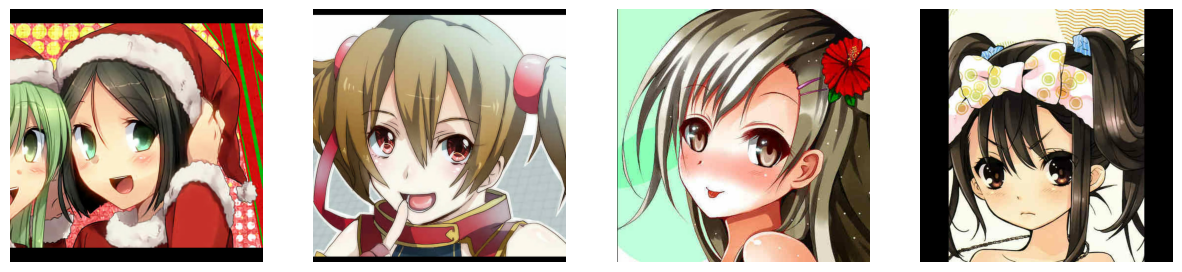

In [6]:
visualize_unbatched_dataset(dataset, 4)

In [7]:
def random_visibility_mask():
    x1 = tf.random.uniform(shape=(), minval=0, maxval=W - 100, dtype=tf.int32)
    y1 = tf.random.uniform(shape=(), minval=0, maxval=H - 100, dtype=tf.int32)
    x2 = tf.random.uniform(shape=(), minval=x1 + 100, maxval=W + 1, dtype=tf.int32)
    y2 = tf.random.uniform(shape=(), minval=y1 + 100, maxval=H + 1, dtype=tf.int32)
    # tf.print(x1,x2,y1,y2)

    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(
            [
                tf.repeat(tf.range(y1, y2), x2 - x1),
                tf.tile(tf.range(x1, x2), [y2 - y1]),
            ],
            axis=-1,
        ),
        updates=tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.bool),
    )
    return mask


def mask_area(mask):
    return tf.reduce_sum(tf.cast(tf.logical_not(mask), tf.int8))


def extract_patches(image: tf.Tensor) -> tf.Tensor:
    "R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"
    # print(image.dtype)

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,  # Add batch dim
        sizes=[1, P, P, 1],  # Patch size
        strides=[1, P, P, 1],  # Step size
        rates=[1, 1, 1, 1],  # No dilation
        padding="VALID",
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    "R^{BS x N x P^2 x C} -> R^{BS x H x W x C}"
    BS = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P

    patches = tf.reshape(patches, [BS, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])

    image = tf.reshape(patches, [BS, grid_size * P, grid_size * P, C])

    return image


def process_mask(mask: tf.Tensor):
    "R^{BS x H x W} -> tuple[R^{BS x N}, R^{BS x N x N}]"
    # viz_mask(mask)
    BS = tf.shape(mask)[0]
    mask = tf.expand_dims(mask, axis=-1)  #  add channel dimension
    mask_pooled = tf.nn.max_pool2d(
        tf.cast(
            tf.logical_not(mask), dtype=tf.int8
        ),  # insane shit happaned here with mask_inverted
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penanly
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )
    # tf.print(tf.shape(A))

    return mask_pooled, A


class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)  # wtf
        self.proj = keras.layers.Dense(D_model, dtype=FLOAT)  # (P² * C) -> D_model
        self.positional_embedding = self.add_weight(
            shape=(1, N, D_model),
            initializer="random_normal",
            trainable=True,
            name="positional_embedding",
            dtype=FLOAT,
        )

    # def build(self, input_shape):
    #     self.call(tf.zeros((BS, N , P**2 * C)))
    #     self.built = True

    def call(self, patches_flat: tf.Tensor):
        # R^{N x (P^2 . C)} -> R^{N x D_model}
        assert patches_flat.dtype == FLOAT
        X = self.proj(patches_flat)  # (N, D_model)
        assert X.dtype == FLOAT
        X += self.positional_embedding  # (N, D_model)
        assert X.dtype == FLOAT
        return X


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.W_Q = keras.layers.Dense(D_model, dtype=FLOAT)
        self.W_K = keras.layers.Dense(D_model, dtype=FLOAT)
        self.W_V = keras.layers.Dense(D_model, dtype=FLOAT)
        self.W_O = keras.layers.Dense(D_model, dtype=FLOAT)

    def call(self, X, A):
        # X: R^{BS x N x D_model}
        # A: R^{BS x N x N}
        # returns: R^{BS x N x D_model}

        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS , N, D_model)
        K = self.W_K(X)  # (BS , N, D_model)
        V = self.W_V(X)  # (BS , N, D_model)

        Q = tf.reshape(Q, (-1, N, h, D_head))
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (4, 4, 1024, 128)
        K = tf.reshape(K, (-1, N, h, D_head))
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.reshape(V, (-1, N, h, D_head))
        V = tf.transpose(V, [0, 2, 1, 3])

        # Compute scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (4, 4, 1024, 1024)
        attn_scores /= tf.math.sqrt(
            tf.cast(D_head, attn_scores.dtype)
        )  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # (BS, 1, N, N)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (BS, h, N, N)

        output = tf.matmul(attn_weights, V)  # (BS, h, N, D_head)
        output = tf.transpose(output, [0, 2, 1, 3])  # (BS, N, h, D_head)
        # tf.print(tf.shape(output))
        combined = tf.reshape(output, (-1, N, D_model))  # (BS, N, D_head)
        # tf.print(tf.shape(combined))

        return self.W_O(combined)  # (BS, N, D_head)


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = MultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(D_fcn, activation="gelu", dtype=FLOAT),
                keras.layers.Dense(D_model, dtype=FLOAT),
                keras.layers.Dropout(0.1, dtype=FLOAT),
            ],
        )

    def call(self, X, A):
        "R^{N x D_model} -> R^{N x D_model}"
        X = self.norm1(X + self.attn(X, A))
        X = self.norm2(X + self.ffn(X))
        return X


class Decoder(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(P * P * C, dtype=FLOAT)

    def call(self, X):
        "R^{BS x N x D_model} -> R^{BS x N x P x P x C}"
        BS = tf.shape(X)[0]
        # print(X.dtype)
        X = self.proj(X)
        X = tf.reshape(X, (BS, N, P, P, C))
        # print(X.dtype)
        # tf.print(tf.shape(X))
        return X


class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = Decoder()

    def build(self, input_shape):
        BS = input_shape[0]
        dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        dummy_masks = tf.stack([random_visibility_mask() for _ in range(BS)])
        self.call(dummy_images, dummy_masks)
        self.built = True

    def call(self, image, mask):
        assert image.dtype == FLOAT

        # print(image.dtype)
        patches = extract_patches(image)
        assert patches.dtype == FLOAT

        mask_pooled, A = process_mask(mask)
        assert A.dtype == FLOAT

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        assert patches_flat.dtype == FLOAT

        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        assert X.dtype == FLOAT

        for block in self.transformer_blocks:
            X = block(X, A)
        assert X.dtype == FLOAT

        reconstructed_patches = self.decoder(X)  # R^{BS x N x P x P x C}
        assert reconstructed_patches.dtype == FLOAT

        reconst_img = patches_to_imgs(reconstructed_patches)
        # tf.print(tf.shape(reconst_img))
        return reconst_img


# mask = random_visibility_mask()
# viz_mask(mask)

model = ImageInpaintingTransformer()
model.build((BS, H, W, C))
model.summary()

img = next(iter(dataset.take(1)))
# visualize_mask_on_image(img,mask)

Model: "image_inpainting_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding                 │ ?                      │       918,016 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │       393,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,921,536 (26.55 MB)

 Trainable params: 13,921,536 (26.55 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#Tests patching and depatching

# img = next(iter(dataset.take(1)))

# viz_img(img)
# patched = extract_patches(tf.expand_dims(img ,0))
# tf.print(tf.shape(patched))

# recreated_img = patches_to_imgs(patched)
# viz_img(recreated_img)


In [10]:
# @tf.function
def l1_masked_loss(y_true: tf.Tensor, y_pred: tf.Tensor, mask: tf.Tensor):
    mask = tf.expand_dims(mask, axis=-1)
    # BS x H x W x C
    # BS x H x W x C
    # BS x H x W
    tf.print(tf.shape(y_true))
    tf.print(tf.shape(y_pred))
    tf.print(tf.shape(mask))
    visible_region = tf.cast(tf.logical_not(mask), FLOAT)
    loss = tf.reduce_sum(
        tf.abs(visible_region * tf.subtract(y_pred, y_true), name="loss"),
        axis=[1, 2, 3],
    )
    normalizer = (
        tf.reduce_sum(visible_region, axis=[1, 2, 3]) + 1e-6
    )
    return tf.reduce_mean(loss / normalizer)


def prepare_sample(image):
    mask = random_visibility_mask()  # Generate a new mask for each image
    return image, mask


dataset_prepared = dataset.map(prepare_sample).batch(BS)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)


# @tf.function
def train_step(image: tf.Tensor, mask: tf.Tensor):
    with tf.GradientTape() as tape:
        reconstructed_img = model(image, mask)  # N x P x P x C
        # tf.print(tf.shape(image))
        # tf.print(tf.shape(reconstructed_img))
        loss = l1_masked_loss(image, reconstructed_img, mask)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


epochs = 10
for epoch in range(epochs):
    epoch_loss: float = 0
    steps = 0
    for image_batch, mask_batch in tqdm(
        dataset_prepared, desc=f"Epoch {epoch+1} ", unit="batch"
    ):
        # tf.print(tf.shape(image_batch))
        loss = train_step(image_batch, mask_batch)
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / steps}")

Epoch 1 : 0batch [00:00, ?batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 1batch [00:01,  1.92s/batch]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 2batch [00:02,  1.09s/batch]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 3batch [00:02,  1.21batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 4batch [00:03,  1.41batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 5batch [00:03,  1.56batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 6batch [00:04,  1.62batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 7batch [00:05,  1.70batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 8batch [00:05,  1.80batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 9batch [00:06,  1.84batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 10batch [00:06,  1.86batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 11batch [00:07,  1.89batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 12batch [00:07,  1.87batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 13batch [00:08,  1.82batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 14batch [00:08,  1.81batch/s]

[2 512 512 3]
[2 512 512 3]
[2 512 512 1]


Epoch 1 : 14batch [00:08,  1.57batch/s]


KeyboardInterrupt: 